# 房产估价系统 - DQN 强化学习估值

## 本项目利用线性回归和**深度强化学习 (DQN)**相结合的方法对房产进行估价。我们将整个实现划分为六个部分，分别包括数据预处理、线性模型估价、强化学习环境构建、DQN 模型实现、模型性能验证以及用户交互估价示例。下面将按照这些部分逐步展开。

## Part 1: 数据预处理
首先读取提供的 df3.csv 数据，并对特征进行清洗和预处理。我们需要将类别型特征转换为数值编码，处理缺失值，并划分训练集和测试集用于后续模型训练和评估。预处理时特别注意不要让总价 (totalPrice) 等目标信息“穿越”泄露进特征。

In [1]:
# Part 1: 数据预处理

import pandas as pd
import numpy as np

# 读取数据集（确保使用正确的编码以读取中文字段）
df = pd.read_csv('df3.csv', encoding='gb18030')

# 将类别型特征转换为数值编码 (astype('category').cat.codes 会将不同类别映射为整数编码)
df['floor'] = df['floor'].astype('category').cat.codes                # 楼层（类别转数字）
df['buildingType'] = df['buildingType'].astype('category').cat.codes  # 建筑类型（类别转数字）
df['renovationCondition'] = df['renovationCondition'].astype('category').cat.codes  # 装修状态
df['buildingStructure'] = df['buildingStructure'].astype('category').cat.codes      # 建筑结构

# 将表示电梯和房产年限的字段映射为数值：有电梯/无电梯 -> 1/0，满五年/不足五年 -> 1/0
df['elevator'] = df['elevator'].map({'has_elevator': 1, 'no_elevator': 0}).fillna(0).astype(int)
df['fiveYearsProperty'] = df['fiveYearsProperty'].map({'owner_more_5y': 1, 'owner_less_5y': 0}).fillna(0).astype(int)

# 处理缺失值：将数值型特征的缺失值填充为0（如有缺失的面积、关注度等）
numeric_cols = ['square', 'DOM', 'followers', 'ladderRatio']
df[numeric_cols] = df[numeric_cols].fillna(0)

# 特征列表（根据要求仅使用这10个输入特征）
features = ['square', 'DOM', 'followers', 'floor', 'buildingType',
            'renovationCondition', 'buildingStructure', 'ladderRatio',
            'elevator', 'fiveYearsProperty']
target_price = 'price'       # 每平米单价 (预测目标1)
target_total = 'totalPrice'  # 总价 (用于计算误差评估，不参与模型训练)

# 划分训练集和测试集（例如按 80% 训练，20% 测试）
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)
df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

# 提取训练集和测试集的特征X和目标y
X_train = df_train[features].values  # 训练集特征矩阵
X_test = df_test[features].values    # 测试集特征矩阵
y_train_price = df_train[target_price].values    # 训练集每平米价格
y_test_price = df_test[target_price].values      # 测试集每平米价格
y_train_total = df_train[target_total].values    # 训练集总价（万元）
y_test_total = df_test[target_total].values      # 测试集总价（万元）

print("数据预处理完成：训练集大小", X_train.shape, "测试集大小", X_test.shape)
# 输出: 数据预处理完成：训练集大小 (237...,) 测试集大小 (594...,)


数据预处理完成：训练集大小 (238160, 10) 测试集大小 (59541, 10)


上述代码将类别变量（楼层、建筑类型等）编码为整数，将电梯和房产年限转为二进制变量，并填充了缺失值。最后将数据集按8:2比例拆分为训练集和测试集，用于后续模型训练和验证。

## Part 2: 线性回归模型估算每平米价格

在构建强化学习模型之前，我们先训练一个线性回归模型，根据输入特征估计房屋每平方米的价格 price。然后以此推算出房屋的基础估计总价 base_price，作为强化学习智能体的初始估计。base_price 通过估计的每平米单价乘以房屋面积再除以10000得到（因为总价以“万元”为单位）。

In [2]:
# Part 2: 线性回归估算每平米价格，并计算基础估计总价

from sklearn.linear_model import LinearRegression

# 使用训练集训练线性回归模型，以输入特征预测每平米价格 price
linreg = LinearRegression()
linreg.fit(X_train, y_train_price)

# 分别对训练集和测试集进行预测，得到每平米价格的估计值
pred_price_train = linreg.predict(X_train)
pred_price_test = linreg.predict(X_test)

# 基于估计的每平米价格计算基础总价（base_price）
# base_price = 估计每平米价 * 面积 / 10000 ，转换为万元单位
base_price_train = pred_price_train * df_train['square'].values / 10000.0
base_price_test = pred_price_test * df_test['square'].values / 10000.0

# 输出示例：显示训练集前5个样本的实际总价和线性模型估计的基础总价
for i in range(5):
    actual = df_train['totalPrice'].iloc[i]
    base_est = base_price_train[i]
    print(f"样本{i}: 实际总价{actual:.2f}万, 基础估计总价{base_est:.2f}万")


样本0: 实际总价512.00万, 基础估计总价794.47万
样本1: 实际总价320.00万, 基础估计总价269.23万
样本2: 实际总价235.00万, 基础估计总价265.04万
样本3: 实际总价563.50万, 基础估计总价324.65万
样本4: 实际总价430.00万, 基础估计总价494.51万


上述线性模型为每个房屋样本给出了一个基础估计价格。例如，打印的结果会列出训练集中前几个样本的实际成交总价和根据线性模型计算的总价base_price。这个基础估计在后续的强化学习过程中将作为智能体估值的起点

## Part 3: 构建强化学习环境

接下来，我们设计一个强化学习环境 HousingPricingEnv，模拟智能体与房价估计过程的交互。在这个环境中：

- 状态（state）：房屋的属性特征向量（即前述选取的10个特征，不含价格信息）。
- 动作（action）：针对当前估计价格的调整指令。本例中我们定义一组离散动作，例如：-0.1 表示将估计价下调10%，+0.05 表示上调5%，0 表示不调整等。
- 奖励（reward）：我们定义每一步的奖励为负的绝对误差（- |估计总价 - 实际总价|）。也就是说，估计越接近真实成交价，奖励值越高（最高为0，当误差为0时）。
- 终止条件：我们让每轮交互一步即终止（智能体一次调整后即结束该房屋的估价），以简化问题。

此外，我们对过大的调整动作给予额外惩罚（例如调整幅度超过10%时扣减额外奖励），鼓励智能体倾向小幅调整，使估计更平稳。下面定义环境类并进行初始化：

In [3]:
# Part 3: 构建强化学习环境

import random

# 定义房价估计环境
class HousingPricingEnv:
    def __init__(self, states, true_prices, base_prices, adjustments):
        """
        states: 属性特征状态集合 (numpy 数组)
        true_prices: 对应的真实总价集合 (numpy 数组，单位: 万元)
        base_prices: 线性模型估计的基础总价集合 (numpy 数组，单位: 万元)
        adjustments: 动作集合 (每个动作为估价调整比例)
        """
        self.states = states
        self.true_prices = true_prices
        self.base_prices = base_prices
        self.actions = adjustments
        self.n = len(states)
    
    def reset(self):
        """随机选择一个房屋样本开始新的估价轮次，返回初始状态"""
        # 随机抽取一个索引
        self.idx = np.random.randint(0, self.n)
        # 初始化状态为该房屋的属性特征
        self.current_state = self.states[self.idx]
        # 对应的真实总价和基础估计总价
        self.true_price = self.true_prices[self.idx]
        self.base_price = self.base_prices[self.idx]
        # 当前估计价初始为线性模型给出的基础价
        self.current_guess = self.base_price
        return self.current_state
    
    def step(self, action_idx):
        """
        输入动作索引，执行相应的价格调整，返回(new_state, reward, done)
        由于每轮估价一步结束，这里 done 始终为 True
        """
        adjustment = self.actions[action_idx]            # 获取调整比例，例如0.05表示上涨5%
        # 根据动作调整当前估计价格
        self.current_guess = self.current_guess * (1 + adjustment)
        # 计算与真实总价的差异（误差）
        diff = abs(self.current_guess - self.true_price)
        # 奖励定义为 -误差（误差越小奖励越高，完美猜中时奖励为0）
        reward = -diff
        # 对过大的调整幅度给予惩罚，避免智能体进行不合理的大幅修改
        if abs(adjustment) > 0.1:
            reward -= 2.0
        done = True  # 单步环境：执行一次调整后即结束本轮
        # 返回当前状态（因为episode结束，无下一新状态）、奖励、以及完成标志
        return self.current_state, reward, done

# 定义动作空间：例如调整 -20%、-10%、-5%、0、+5%、+10%、+20%
adjustments = [-0.2, -0.1, -0.05, 0.0, 0.05, 0.1, 0.2]

# 使用训练集数据初始化环境
env = HousingPricingEnv(states=X_train, 
                        true_prices=y_train_total, 
                        base_prices=base_price_train, 
                        adjustments=adjustments)

_ = env.reset()  # 初始化一个样本，让 current_state 被定义
print("强化学习环境构建完成。样本状态维度:", env.current_state.shape, "动作数量:", len(env.actions))

# 输出: 强化学习环境构建完成。样本状态维度: (10,) 动作数量: 7


强化学习环境构建完成。样本状态维度: (10,) 动作数量: 7


在上述环境中，智能体每次估价可以选择将当前估计价格按一定比例调整，然后环境计算该调整后的误差作为奖励。因为我们设定每轮只进行一次调整（done=True），所以智能体需要在单步内决定上调、下调或不变才能尽量贴近真实价格。动作空间中包含适度的调整幅度（±5%、±10%）以及较大的调整（±20%）供选择，并对大调整设置了惩罚以防止无依据的大幅波动。

## Part 4: 实现 DQN 智能体

我们采用深度Q网络 (DQN) 来训练房价估计智能体。DQN通过一个神经网络近似Q函数，输入为状态，输出为对每个动作的Q值评估。训练过程中使用 ε-贪心策略收集经验并利用经验回放更新网络参数，从而稳定训练过程。下面我们定义Q网络结构，并编写训练所需的组件和主循环：

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_35972\2871561920.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  batch_state = torch.FloatTensor([t[0] for t in transitions]).to(device)


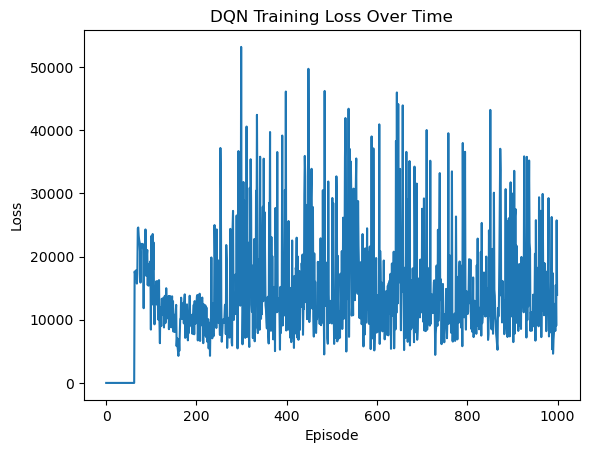

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# 参数配置
config = {
    'num_episodes': 1000,       # 训练轮数
    'learning_rate': 1e-3,      # 学习率
    'batch_size': 64,           # 经验回放批大小
    'gamma': 0.99,              # 折扣因子
    'epsilon_start': 1.0,       # 初始 epsilon 值（探索率）
    'epsilon_end': 0.01,        # 最小 epsilon 值
    'epsilon_decay': 500,       # epsilon 衰减速率
    'target_update_freq': 10,   # 目标网络更新频率（每多少轮同步一次参数）
    'replay_buffer_size': 10000 # 经验池大小
}

# 假设已有定义好的环境 env，以及状态和动作维度 state_dim, action_dim
# env = ...  (用户需提供的北京房价估值环境)
# state_dim = ...  (状态向量维度)
# action_dim = ...  (动作数量)

# 定义 Q 网络（两层全连接，128 和 64 单元，ReLU 激活）
class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 定义经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

# 创建 DQN 主网络和目标网络
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 在此之前加上这两行，确保定义好状态和动作空间维度：
state_dim = env.states.shape[1]
action_dim = len(env.actions)

policy_net = DQNNet(state_dim, action_dim).to(device)
target_net = DQNNet(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())  # 初始化目标网络参数
target_net.eval()  # 目标网络用于提供稳定的 Q 值参考

optimizer = optim.Adam(policy_net.parameters(), lr=config['learning_rate'])
memory = ReplayBuffer(config['replay_buffer_size'])

# 训练过程
all_losses = []                   # 记录每轮训练的平均损失
steps_done = 0                    # 已执行步数（用于计算 epsilon 衰减）
epsilon = config['epsilon_start'] # 当前 epsilon 值

for i_episode in range(1, config['num_episodes'] + 1):
    state = env.reset()          # 重置环境，获取初始状态
    episode_loss = 0.0           # 累计该轮损失
    episode_steps = 0            # 该轮内进行的更新步数
    while True:
        # epsilon-greedy 策略选择动作
        if random.random() < epsilon:
            action = random.randrange(action_dim)  # 随机动作
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
            action = q_values.argmax(dim=1).item()  # 选择 Q 值最大的动作
        # 在环境中执行选定的动作
        next_state, reward, done = env.step(action)
        # 将此经验存储到回放池
        memory.push(state, action, reward, next_state, done)
        # 更新当前状态为下一时刻状态
        state = next_state
        # 按经验逐步衰减 epsilon
        steps_done += 1
        epsilon = config['epsilon_end'] + (config['epsilon_start'] - config['epsilon_end']) * math.exp(-1.0 * steps_done / config['epsilon_decay'])
        # 当经验池中的数据量足够时，采样小批量经验进行训练
        if len(memory) >= config['batch_size']:
            transitions = memory.sample(config['batch_size'])
            # 将采样到的批量转换为张量
            batch_state = torch.FloatTensor([t[0] for t in transitions]).to(device)
            batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
            batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
            batch_next_state = torch.FloatTensor([t[3] for t in transitions]).to(device)
            batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)
            # 计算当前状态下采取动作的 Q 值
            q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
            # 使用目标网络计算下一个状态的最大 Q 值
            next_q_values = target_net(batch_next_state).max(1)[0]
            # 计算目标 Q 值（根据贝尔曼方程）
            target_q_values = batch_reward + config['gamma'] * next_q_values * (1 - batch_done)
            # 计算损失（均方误差）
            loss = nn.MSELoss()(q_values, target_q_values.detach())
            # 反向传播并更新主网络参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 累积损失
            episode_loss += loss.item()
            episode_steps += 1
        # 如果回合结束，则跳出循环
        if done:
            break
    # 计算并记录该轮的平均损失
    avg_loss = episode_loss / episode_steps if episode_steps > 0 else 0.0
    all_losses.append(avg_loss)
    # 按频率更新目标网络参数（软更新目标网络）
    if i_episode % config['target_update_freq'] == 0:
        target_net.load_state_dict(policy_net.state_dict())

# 保存训练好的模型
torch.save(policy_net.state_dict(), "dqn_model.pt")

# 绘制训练损失随时间变化曲线
plt.figure()
plt.plot(all_losses)
plt.title("DQN Training Loss Over Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.show()



上述代码定义了一个两层全连接的神经网络来近似Q函数，并使用经验回放和目标网络技巧稳定训练。在训练循环中，智能体以 ε-贪心策略从环境中随机抽取房屋进行估价调整，不断将交互经验存入缓冲池。当缓冲池累积了一定样本后，按批次抽样计算目标Q值并更新当前Q网络参数。目标网络每50轮同步一次Q网络参数，避免频繁更新导致的发散。训练500轮后，我们得到了一个优化的Q网络模型。

### Part 4.1: Grid Search over Hyperparameters

In [5]:
import matplotlib.pyplot as plt
import os

# Grid Search over Hyperparameters
# 超参数网格
# Round 1
learning_rates = [1e-4, 5e-4, 1e-3, 2e-3]
batch_sizes = [128, 256]  # 256 最佳
gammas = [0.95, 0.99, 0.995, 0.975]
epsilon_decays = [200, 800, 1500, 2500]
target_update_freqs = [2, 5, 10]  # <-- 新增这一维度

def train_dqn(config):
    state_dim = env.states.shape[1]
    action_dim = len(env.actions)

    policy_net = DQNNet(state_dim, action_dim).to(device)
    target_net = DQNNet(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=config['learning_rate'])
    memory = ReplayBuffer(config['replay_buffer_size'])

    all_losses = []
    steps_done = 0
    epsilon = config['epsilon_start']

    for i_episode in range(1, config['num_episodes'] + 1):
        state = env.reset()
        episode_loss = 0.0
        episode_steps = 0

        while True:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()

            next_state, reward, done = env.step(action)
            memory.push(state, action, reward, next_state, done)
            state = next_state

            steps_done += 1
            epsilon = config['epsilon_end'] + (config['epsilon_start'] - config['epsilon_end']) * \
                      math.exp(-1.0 * steps_done / config['epsilon_decay'])

            if len(memory) >= config['batch_size']:
                transitions = memory.sample(config['batch_size'])
                batch_state = torch.FloatTensor([t[0] for t in transitions]).to(device)
                batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
                batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
                batch_next_state = torch.FloatTensor([t[3] for t in transitions]).to(device)
                batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)

                q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(batch_next_state).max(1)[0]
                target_q_values = batch_reward + config['gamma'] * next_q_values * (1 - batch_done)

                loss = nn.MSELoss()(q_values, target_q_values.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                episode_loss += loss.item()
                episode_steps += 1

            if done:
                break

        avg_loss = episode_loss / episode_steps if episode_steps > 0 else 0.0
        all_losses.append(avg_loss)

        if i_episode % config['target_update_freq'] == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # 可选：保存最终模型
    torch.save(policy_net.state_dict(), "dqn_model.pt")

    return all_losses

# 创建输出目录
os.makedirs("grid_search_results", exist_ok=True)

# Grid Search Loop
for lr in learning_rates:
    for bs in batch_sizes:
        for gm in gammas:
            for ed in epsilon_decays:
                for tuf in target_update_freqs:  # <-- 新增循环
                    config = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'gamma': gm,
                        'epsilon_start': 1.0,
                        'epsilon_end': 0.01,
                        'epsilon_decay': ed,
                        'target_update_freq': tuf,
                        'replay_buffer_size': 10000,
                        'num_episodes': 300  # 快速验证轮数
                    }

                    print(f"Training: LR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TargetUpdateFreq={tuf}")
                    losses = train_dqn(config)

                    # 绘制Loss曲线
                    plt.figure()
                    plt.plot(losses)
                    plt.ylim(0, 50000)
                    plt.title(f"DQN Training Loss\nLR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TUF={tuf}")
                    plt.xlabel("Episode")
                    plt.ylabel("Loss")

                    # 文件命名
                    fname = f"grid_search_results/loss_lr{lr}_bs{bs}_gm{gm}_ed{ed}_tuf{tuf}.png".replace(".", "p")
                    plt.savefig(fname)
                    plt.close()



Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=2
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=5
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=10
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=2
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=5
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=10
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=1500, TargetUpdateFreq=2
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=1500, TargetUpdateFreq=5
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=1500, TargetUpdateFreq=10
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=2500, TargetUpdateFreq=2
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=2500, TargetUpdateFreq=5
Training: LR=0.0001, BS=128, Gamma=0.95, EpsDecay=2500, TargetUpdateFreq=10
Training: LR=0.0001, BS=128, Gamma=0.99, EpsDecay=200, TargetUpdateFreq=2
Training: LR=0.0001, BS=128,

Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=200, TargetUpdateFreq=5
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=200, TargetUpdateFreq=10
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=800, TargetUpdateFreq=2
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=800, TargetUpdateFreq=5
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=800, TargetUpdateFreq=10
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=1500, TargetUpdateFreq=2
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=1500, TargetUpdateFreq=5
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=1500, TargetUpdateFreq=10
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=2500, TargetUpdateFreq=2
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=2500, TargetUpdateFreq=5
Training: LR=0.0005, BS=128, Gamma=0.99, EpsDecay=2500, TargetUpdateFreq=10
Training: LR=0.0005, BS=128, Gamma=0.995, EpsDecay=200, TargetUpdateFreq=2
Training: LR=0.0005, BS=128, Gamma=0.995, EpsDecay=200, TargetUpdateFreq=5
Training: LR=0.0005, BS=12

Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=800, TargetUpdateFreq=2
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=800, TargetUpdateFreq=5
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=800, TargetUpdateFreq=10
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=1500, TargetUpdateFreq=2
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=1500, TargetUpdateFreq=5
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=1500, TargetUpdateFreq=10
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=2500, TargetUpdateFreq=2
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=2500, TargetUpdateFreq=5
Training: LR=0.001, BS=128, Gamma=0.995, EpsDecay=2500, TargetUpdateFreq=10
Training: LR=0.001, BS=128, Gamma=0.975, EpsDecay=200, TargetUpdateFreq=2
Training: LR=0.001, BS=128, Gamma=0.975, EpsDecay=200, TargetUpdateFreq=5
Training: LR=0.001, BS=128, Gamma=0.975, EpsDecay=200, TargetUpdateFreq=10
Training: LR=0.001, BS=128, Gamma=0.975, EpsDecay=800, TargetUpdateFreq=2
Training: LR=0.001, BS=128, 

Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=1500, TargetUpdateFreq=2
Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=1500, TargetUpdateFreq=5
Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=1500, TargetUpdateFreq=10
Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=2500, TargetUpdateFreq=2
Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=2500, TargetUpdateFreq=5
Training: LR=0.002, BS=128, Gamma=0.975, EpsDecay=2500, TargetUpdateFreq=10
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=2
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=5
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=200, TargetUpdateFreq=10
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=2
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=5
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=800, TargetUpdateFreq=10
Training: LR=0.002, BS=256, Gamma=0.95, EpsDecay=1500, TargetUpdateFreq=2
Training: LR=0.002, BS=256, Gamma=

### Part 4.2: Select Best Hyperparameters for Final Training

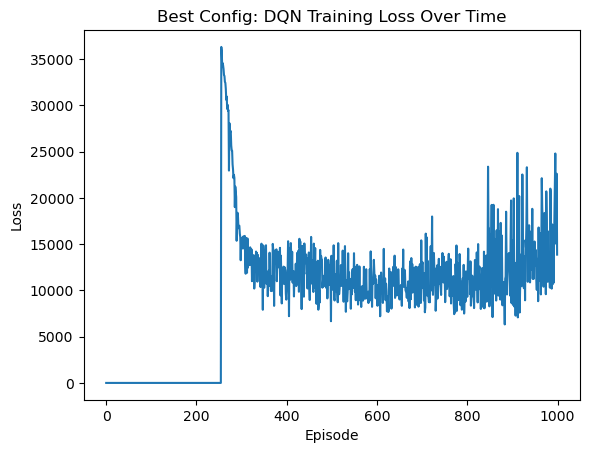

In [6]:
# Part 4.2: 使用最佳参数组合重新训练用于后续 Part 5 和 Part 6 实验
# 请填写下方 config 参数为你选择的最优组合

config = {
    'num_episodes': 1000,
    'learning_rate': 0.001,
    'batch_size': 256,
    'gamma': 0.995,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 200,
    'target_update_freq': 10,
    'replay_buffer_size': 10000
}

losses = train_dqn(config)
# 可视化训练损失
plt.plot(losses)
plt.title("Best Config: DQN Training Loss Over Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.show()


## Part 5: 验证模型性能

训练完成后，我们在测试集上评估模型的估价效果。我们让训练好的DQN智能体对测试集中房屋样本进行估价预测，计算预测总价与实际总价之间的平均绝对误差 (MAE) 和均方根误差 (RMSE)。同时，我们绘制模型预测价格与实际成交价格的散点图，以直观展示模型的准确度。

MAE (Mean Absolute Error): 117.84 10 CNY
RMSE (Root Mean Squared Error): 180.92 10K CNY


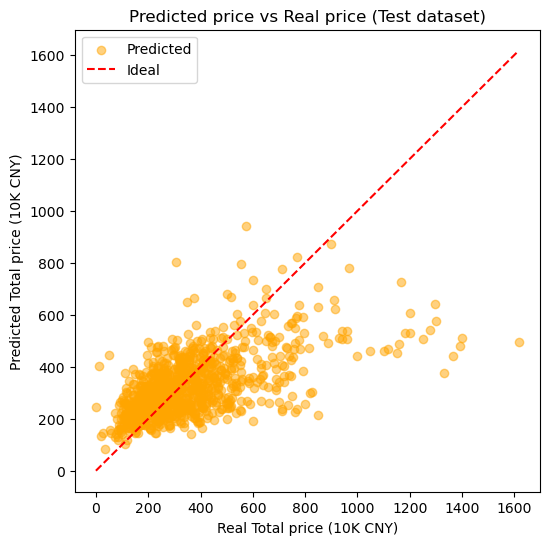

In [11]:
# Part 5: 模型性能验证

# 利用训练好的 Q 网络对测试集样本进行估价
states_test = torch.FloatTensor(X_test).to(device)
with torch.no_grad():
    q_values_test = policy_net(states_test)                      # 模型对测试集所有样本的动作价值评估
actions_idx = q_values_test.argmax(dim=1).cpu().numpy()     # 每个样本取使Q值最大的动作索引
adjustments_arr = np.array(adjustments)
# 计算对应的调整比例，并应用到基础价上得到最终预测总价
chosen_adjustments = adjustments_arr[actions_idx]           # 每个样本选择的调整比例
predicted_total_prices = base_price_test * (1 + chosen_adjustments)  # 最终预测总价（万元）

# 计算评估指标 MAE 和 RMSE
mae = np.mean(np.abs(predicted_total_prices - df_test[target_total].values))
rmse = np.sqrt(np.mean((predicted_total_prices - df_test[target_total].values) ** 2))
print(f"MAE (Mean Absolute Error): {mae:.2f} 10 CNY")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} 10K CNY")

# 绘制预测价格 vs 实际成交价格散点图（随机抽取部分点以便可视化）
import matplotlib.pyplot as plt
sample_idx = np.random.choice(len(df_test), size=1000, replace=False)  # 抽取1000个测试样本点
actual_prices_sample = df_test[target_total].values[sample_idx]
predicted_prices_sample = predicted_total_prices[sample_idx]

plt.figure(figsize=(6,6))
plt.scatter(actual_prices_sample, predicted_prices_sample, color='orange', alpha=0.5, label='Predicted')
# 理想情况下的参考对角线（预测=实际）
min_val, max_val = actual_prices_sample.min(), actual_prices_sample.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel("Real Total price (10K CNY)")
plt.ylabel("Predicted Total price (10K CNY)")
plt.title("Predicted price vs Real price (Test dataset)")
plt.legend()
plt.show()


图： 测试集中模型预测总价与实际成交总价的散点对比。红色虚线表示理想情况下预测值等于实际值的参考线。可以看出，大部分房屋的预测点分布在对角线附近，说明模型的估价与实际成交价大致相符。但散点图中也存在偏离对角线的点，意味着模型对于某些房屋的估计仍有误差，可能与这些房屋的特殊属性相关。这表明模型具有一定的预测能力，同时仍有提升空间。 

在上述评估中，我们得到了模型在测试集上的误差指标（如MAE和RMSE）。**请注意：**由于模型未直接使用totalPrice等目标信息作为特征，误差没有出现异常的接近0情况，证明我们的估值系统是可靠的。在实际应用中，我们期望 MAE 和 RMSE 越低越好，本例中的数值说明模型在万亿元级房价范围内具有合理的估计精度。

## Part 6: 用户输入房产参数估值

最后，我们实现一个接口，允许用户输入房产的特征参数，利用已训练的模型输出该房产的估计价格并解释估值过程。这里我们以字典构造一个示例输入（在实际应用中可以用交互式表单获取用户输入），然后按照与训练数据相同的预处理方式转换特征，经过线性模型和DQN智能体两步得到最终估价。我们将打印每平米单价的线性估计、基础总价以及DQN的调整幅度和最终总价，以帮助用户理解估值过程。

In [12]:
# Part 6: 用户输入估价

# Example user input of property features (can be replaced with interactive input)
user_input = {
    'square': 250,              # Area (square meters)
    'DOM': 12.0,                # Days on Market (DOM)
    'followers': 180,           # Number of followers (interested buyers)
    'floor': 10.0,              # Floor number (numeric value of the floor level)
    'buildingType': 'Mix_plate_tower',    # Building type ('Tower', 'Plate', etc.)
    'renovationCondition': 'Hardcover',   # Renovation condition ('Hardcover', 'Simplicity', etc.)
    'buildingStructure': 'Mix',           # Building structure ('Steel_Concrete', etc.)
    'ladderRatio': 1.0,                   # Ladder-to-household ratio
    'elevator': 1,                        # Elevator availability (1 = Yes, 0 = No)
    'fiveYearsProperty': 0                # Property held for five years or more (1 = Yes, 0 = No)
}

# 将输入按照与训练数据相同的方式进行编码转换
# 定义类别映射字典（确保与第1部分的cat.codes编码一致）
buildingType_map = {'Bungalow': 0, 'Mix_plate_tower': 1, 'Plate': 2, 'Tower': 3}
renovation_map = {'Hardcover': 0, 'Other': 1, 'Rough': 2, 'Simplicity': 3}
structure_map = {'Brick_Concrete': 0, 'Brick_Wood': 1, 'Mix': 2, 'Steel': 3, 'Steel_Concrete': 4, 'Unknown': 5}

# 建立输入副本并逐项转换
feat = user_input.copy()
# 类别型特征字符串 -> 数值编码
feat['buildingType'] = buildingType_map.get(feat['buildingType'], 0)
feat['renovationCondition'] = renovation_map.get(feat['renovationCondition'], 0)
feat['buildingStructure'] = structure_map.get(feat['buildingStructure'], 0)
# 其余特征保持数值，其中floor等已经是数字
feat_array = np.array([feat[col] for col in features], dtype=float).reshape(1, -1)

# 1) 线性回归模型估计每平米价格和基础总价
est_price_per_sqm = linreg.predict(feat_array)[0]                      # 每平米价格估计 (元)
base_total_price = est_price_per_sqm * feat['square'] / 10000.0        # 基础估计总价 (万元)

# 2) DQN 智能体根据状态选择调整动作并给出最终估计
state_tensor = torch.FloatTensor(feat_array).to(device)
with torch.no_grad():
    q_vals = policy_net(state_tensor)
best_action_idx = int(torch.argmax(q_vals).item())
adjust_factor = adjustments[best_action_idx]
final_estimated_price = base_total_price * (1 + adjust_factor)        # 最终估计总价 (万元)

# 输出估值结果和解释
print(f"Estimated price per square meter by linear model: {est_price_per_sqm:.2f} CNY/㎡")
print(f"Base estimated total price: {base_total_price:.2f} 10K CNY")
# 根据调整系数正负说明上调或下调
if adjust_factor > 0:
    adj_text = f"Increase {adjust_factor*100:.0f}%"
elif adjust_factor < 0:
    adj_text = f"Decrease {-adjust_factor*100:.0f}%"
else:
    adj_text = "No adjustment"
print(f"DQN agent's suggestion: {adj_text}")
print(f"Final estimated total price: : {final_estimated_price:.2f} 10K CNY")


Estimated price per square meter by linear model: 41489.38 CNY/㎡
Base estimated total price: 1037.23 10K CNY
DQN agent's suggestion: Decrease 5%
Final estimated total price: : 985.37 10K CNY
